Deep Learning
=============

Here we attempt to load, explore and clean if required the data from street view housing numbers dataset. 

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from IPython.display import display, Image
from scipy import ndimage
from scipy import io
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve
import pandas as pd
import tarfile
from collections import defaultdict

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, url, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('data.tar.gz', 'https://www.dropbox.com/s/yiogni0r2ac2aym/data.tar.gz?dl=1', 184858650)

Found and verified data.tar.gz


In [4]:
if not os.path.isdir('data'):
    tar = tarfile.open('data.tar.gz')
    sys.stdout.flush()
    tar.extractall()
    tar.close()

In [5]:
# read the digitStruct.csv file and augment it with useful information
def read_csv(filename):

    df = pd.read_csv(filename)
    df['LabelCount'] = df.DigitLabel
    df.DigitLabel = df['DigitLabel'].replace(10, 0)
    # right and bottom most offsets
    df['RightMost'] = df.Left + df.Width
    df['BottomMost'] = df.Top + df.Height

    grouped = df.groupby(['FileName'])
    agg = grouped.agg({'Left': np.min, 'Top': np.min, 'BottomMost': np.max, 'RightMost': np.max, 'LabelCount': np.size, 'DigitLabel': lambda x: tuple(x)})
    agg['Height'] = agg.BottomMost - agg.Top
    agg['Width'] = agg.RightMost - agg.Left
    return agg

In [6]:
image_size = 48  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, csvData):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size, 3),
                         dtype=np.float32)
  # length and 5 digits - 10 to signify absence of a digit in sequence
  labels = np.ndarray(shape=(len(image_files), 6), dtype=np.int8)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      # first - label data
      label_data = csvData.loc[image]
      numbers = list(label_data.DigitLabel)
      # if length of the numbers is less than 5, pad it with 10s
      if len(numbers) < 5:
        numbers += [10]*(5-len(numbers))
      elif len(numbers) > 5:
        continue # skip this image. number of digits more than 5
      
      length = label_data.LabelCount-1 # lengths as labels from 0 to 4 where they are actually (1 to 5)
      labels[num_images, :] = np.array([length] + numbers)
    
      # now image data
      image_data = ndimage.imread(image_file).astype(float)
      if image_data.shape != (image_size, image_size, 3):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :, :] = image_data        
    
      # Increment the index counter
      num_images = num_images + 1
      
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :, :]
  labels = labels[0:num_images, :]
  
  print('Full dataset tensor:', dataset.shape)
  print('Full labels tensor:', labels.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return (dataset, labels)

train_dataset, train_labels = load_letter('data/train', read_csv('data/train_digitStruct.csv'))
test_dataset, test_labels = load_letter('data/test', read_csv('data/test_digitStruct.csv'))

data/train
Full dataset tensor: (33364, 48, 48, 3)
Full labels tensor: (33364, 6)
Mean: 139.51
Standard deviation: 60.5017
data/test
Full dataset tensor: (13060, 48, 48, 3)
Full labels tensor: (13060, 6)
Mean: 135.12
Standard deviation: 65.288


In [6]:
tr_df = read_csv('data/train_digitStruct.csv')
ts_df = read_csv('data/test_digitStruct.csv')

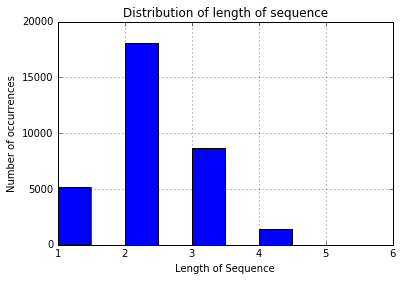

In [11]:
plt.xlabel('Length of Sequence')
plt.ylabel('Number of occurrences')
plt.title('Distribution of length of sequence')
tr_df.LabelCount.hist()

In [28]:
ldf = tr_df.DigitLabel.apply(pd.Series)

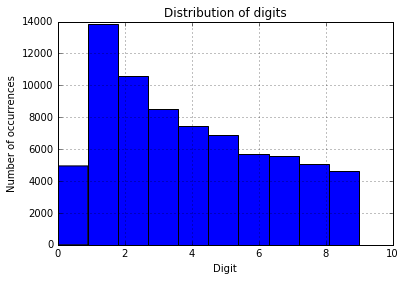

In [29]:
plt.xlabel('Digit')
plt.ylabel('Number of occurrences')
plt.title('Distribution of digits')
ldf = pd.concat([ldf[x] for x in range(6)])
ldf.hist()

In [25]:
tr_df.groupby(['LabelCount'])['Top'].count()

LabelCount
1     5135
2    18126
3     8689
4     1433
5        9
6        1
Name: Top, dtype: int64

73237